## AJ Data Pre-Processing

In [66]:
import os
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import re
import csv
import json
import numpy as np
import tcxparser
import glob
import time
import statistics
import numpy
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

#### Relevant Parameters of interest (user specific)

In [6]:
paths_to_data = {'fit':'../Data/Juan/Run/Fit', 'arduino':'../Data/Juan/Run'}
data_dir = '../Data/Juan/Run/'

path_to_tcx = 'Actividades/*_Correr.tcx'

file_names = sorted(glob.iglob(os.path.join(paths_to_data['fit'], path_to_tcx)))


In [7]:
def missing_data_treatment(data, method='interpolation'):
    """
    We see that the arduino app generates a lot of missing data points. We will implement a few different approaches to 
    deal with this missing data:
    :param method: (str) The methods we will implement are:
        - 'constant': Will adopt the value of the previous observation
        - 'interpolation': Interpolate the data since we are in a continuous domain
        - 'nearest': Adopts the value of the nearest value
    """
    df = data.copy()
    if method == 'interpolation':
        df.interpolate(method='linear', inplace=True)
    elif method == 'constant':
        df.interpolate(method='zero', inplace=True)
    elif method == 'nearest':
        df.interpolate(method='nearest', inplace=True)
    else:
        raise ValueError('The method specified is not defined. Please review function missing_data_treeatment')
    return df

In [8]:
def session_start(data, method='inference', value=None):
    """
    Sessions don't start in the moment in which Arduino starts recording data. There are a few residual seconds before
    we actually start running (e.g. setting up device). 
    We will implement 3 different methods:
    :param method: (str) 
        - 'inference': Look at the data and try to guess when we are actually starting to run. The idea until now is:
                - Look at the X, Y and Z axis for each user and see the most regular one (depends on how the device is placed).
                - Based on the best feature, estimate the average amplitude of a step (Avarage amplitude is calculated for each interval of n measurements)
                - Start is defined as the starting point of the first interval wich passes the avg threshold.
                - End is defined as the starting point of the first interval (from the end of the time series) wich passes the avg threshold.
                - Set the timer at the stage in which the amplitude is below a certain threshold
        - 'percentage': Remove the initial 2% of the observations (try to be conservative, better to remove part of the session
                        than keep irrelevant data)
        - 'fixed': Set a fixed starting point (not recommended but  can be usefull for testing purposes)
    :param value: (depends) If the method is  inference leave the default value, if the method is percentage provide float 
                  between 0 and 1 (e.g. 0.02 to remove  2% of the initial data set), if the method is fixed provide a string 
                  with date format (e.g. '2021-05-02 18:01:00')
    """
    
    df = data.copy().dropna()
    if method == 'inference':
        
        n = 100 # n=100 seemed like a good compromise to me in order to avoid detecting local changes.
        Y = [abs(x) for x in df.AccY.tolist()]
        ampl = [statistics.mean(Y[x:x+n]) for x in range(1,(len(Y)//n)*n,n)]
        start = np.where(np.array(ampl) > statistics.mean(ampl))[0][0]*n
        end = np.where(np.array(ampl[::-1]) > statistics.mean(ampl))[0][0]*n
        start_timestamp = df.iloc[[start]].index[0]
        end_timestamp = df.iloc[[len(Y)-end-1]].index[0]
        print('Number of observations excluded with inference method:', start+end)
        
        ########################## to be deleted, just for check
        plt.figure(figsize=(20,8))
        plt.plot(df.AccY.tolist(),color='#F7EBE8')
        plt.axvline(x=start, color='g', linestyle='--')
        plt.axvline(x=len(Y)-end, color='r', linestyle='--')
        plt.show()
        #######################################################
        
        df = df[df.index > start_timestamp]
        df = df[df.index < end_timestamp]
        
    elif method == 'percentage':
        length = len(data)*value
        df = df[int(length):]
    elif method == 'fixed':
        df = df[df > value]
    else:
        raise ValueError('The method specified is not defined. Please review function session_start')
    
    return df

In [373]:
def generate_full_time_series_AJ(path, file_identifier='Run_', plot=None, google_files=file_names, period=1,
                                 independence_df=False, distance=distance_vec, feature='AccY', plot_check=[1000,1500],
                                 step_per_peak=1, history=2, time_interval='5S'):
    
    """
    We have decided to generate a full time series as dataset (i.e. put all the sessions together, making several 
    time series into a single one). For this purpose we will simply do individual pre-processing steps on each 
    of the csv files and then merge everything together
    :param path: (str) Folder in which csv files can be found
    :param file_identifier: (str) Identifier of each csv file
    :param period: Number of periods between pace run
    :param independence_df: If true we will generate dataframes assuming independence
    :param distance: Used only for the step function detector
    :param feature: Used only for the step function detector
    :param plot_check: Used only for the step function detector
    :param history: How much back do we want to go to remove independence?
    :param time_interval: Aggregation time interval
    """
    session_files =  [i for i in os.listdir(path) if re.search(file_identifier, i)] 
    full_df = pd.DataFrame()
    
    google_df = load_tcx(google_files)
    j=0
    for session in session_files:
        print('Session Identifier: ', re.findall('\d+', session)[0])
        df = pd.read_csv(path + session)
        df['timestamp'] = df.apply(lambda x: datetime.fromtimestamp(x['timestamp'] / 1000).strftime('%Y-%m-%d %H:%M:%S.%f')[:-3] ,axis=1)
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df = df.set_index('timestamp')
        df_missing = missing_data_treatment(df, method='interpolation')
        df_start = session_start(df_missing, method='inference',value=None)
        #print('Session Start: ' + str(min(df_start.index)))
        #print('Session End: ' + str(max(df_start.index)))
        reduce_tcx_df = google_df[(google_df.timestamp > str(min(df_start.index))) & 
                                  (google_df.timestamp < str(max(df_start.index)))].set_index('timestamp')
        
        
        #return reduce_tcx_df, df_start
        # Intermediate step to remove google data duplicates for distance and altitude seperately
        reduce_tcx_df.reset_index(level=0, inplace=True)
        dist_df = reduce_tcx_df.groupby('distance').last().reset_index(level=0).set_index('timestamp')
        alt_df = reduce_tcx_df.groupby('altitude').last().reset_index(level=0).set_index('timestamp')
        
        merged = df_start.merge(dist_df[['distance', 'google_fit']], how='outer', sort=True, on='timestamp')
        merged['distance'] = merged['distance'].interpolate(method='index')
        
        merged = merged.merge(alt_df[['altitude', 'google_fit']], how='outer', sort=True, on='timestamp')
        merged['altitude'] = merged['altitude'].interpolate(method='index')
        
        
        df_final = merged[~(merged.google_fit_x == True) | ~(merged.google_fit_y == True)]
        #df_final.dropna(subset=['altitude', 'distance'], inplace=True)
        df_final.drop(columns=['google_fit_x', 'google_fit_y'], inplace=True)
        df_final = df_final[(df_final.index > str(min(df_start.index))) & 
                             (df_final.index < str(max(df_start.index)))]
        
        # Add pace to as feature
        df_final['delta_distance']= df_final.distance.diff(periods=period)
        df_final['delta_time'] = [0]*period+[(df_final.index[i]-df_final.index[i-period]).total_seconds() 
                                                for i in range(period,df_final.shape[0])]
        df_final = df_final[period:]
        df_final['pace']=(df_final.delta_distance/1000)/(df_final.delta_time/3600)
        
        if independence_df:
            df_peaks = identify_peaks(df_final, feature=feature, plot_check=plot_check, distance=distance_vec[j],
                                      step_per_peak=step_per_peak)
            df_agg = df_aggregation(df_peaks, time_interval=time_interval, history=2)
            df_agg.dropna(inplace=True)
            full_df = pd.concat([full_df, df_agg])
        else:
            full_df = pd.concat([full_df, df_final])        
        print('+++++++++++++++')
        j+=1
        
    print('Finished pre-processing individual time series')
    full_df.sort_values(by='timestamp', inplace=True)
    
    if plot:
        plt.figure(figsize=(20, 12))
        plt.plot(full_df[plot])
        plt.show()
     
    
    return full_df
    

In [10]:
def load_tcx(file_list):
   
    """
    Load tcx files into pandas DataFrame
    
    Known issue: 
    the lists altitude, timestamp and distance have not the same length;
    we don't know the position of the missing data (potential values' shift);
    """
    df = pd.DataFrame(columns=['timestamp','altitude',
                               'distance', 
                               'google_fit'])
    
    for file in file_list:
        tcx_obj = tcxparser.TCXParser(file)
        default_len = min([len(tcx_obj.time_values())],
                          [len(tcx_obj.altitude_points())],
                          [len(tcx_obj.distance_values())])[0]
        data_dict = {'timestamp':tcx_obj.time_values()[-default_len:], 
                     'altitude':tcx_obj.altitude_points()[-default_len:], 
                     'distance':tcx_obj.distance_values()[-default_len:],
                     'google_fit': [True] * default_len}
        tmp_df = pd.DataFrame.from_dict(data_dict)
        df = pd.concat([df, tmp_df], ignore_index=True)
        print('======================')
        
    df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y-%m-%dT%H:%M:%S.%fZ")
    hours_added = timedelta(hours = 2)
    df['timestamp'] = df['timestamp'] + hours_added
    df['distance'] = pd.to_numeric(df.distance.astype(str))
        
    return df.sort_values(by='timestamp')

In [374]:
def identify_peaks(data, feature='AccY', height=0, distance=20, plot_check=[10000, 15000], step_per_peak=1):
    """
    For this function we provide a dataset and we return the same dataset with two additional features:
     - step: Indicator of when a set has been made. Since this estimation is based on the Acc it will in reality be 2 steps
     - peak_height: Moment in which the peak was identified, what was the height of the peak
    :param data: Dataframe where we will include the features
    :param feature: What is the feature variable over which this estimation will be done (this will depend on the run session)
    :param height: Reference value for peak_height
    :param distance: Minimum distance in index terms between two peaks. This is a tunning parameter which depends on the 
        session
    :param step_per_peak: How many steps for each peak detected
    :param plot_check: If provided, as output we will also get a plot to see whether the step checker has worked properly
    **Disclaimer: This is not an exact appproach, rather an approximation. Therefore this should be done ideally for each
        individual session independently
    """
    
    df = data.copy()
    x = np.array(df[feature])
    peaks, properties = find_peaks(x, height=height, distance=distance)
    if plot_check:
        plt.figure(figsize=(15, 8))
        plt.plot(x)
        plt.plot(peaks, x[peaks], "x")
        plt.plot(np.zeros_like(x), "--", color="gray")
        plt.xlim(plot_check[0], plot_check[1])
        plt.show()
    
    step = [0]*len(df)
    peak_height = [0]*len(df)
    j = 0
    for i in peaks:
        step[i] = step_per_peak
        peak_height[i] = properties['peak_heights'][j]
        j+=1

    df['step'] = step
    df['peak_height'] = peak_height
    
    return df

In [ ]:
def df_aggregation(df, time_interval='5S', history=2):
    
    # Perform aggregation
    ind_df = df.groupby(pd.Grouper(freq=time_interval)).agg({'AccX':['min', 'max', 'mean', 'median', 'std'], 
                                                        'AccY':['min', 'max', 'mean', 'median', 'std'],
                                                        'AccZ':['min', 'max', 'mean', 'median', 'std'],
                                                        'DecibelSource':['min', 'max', 'mean', 'median', 'std'],
                                                        'PitchSensor':['min', 'max', 'mean', 'median', 'std'],
                                                        'LinearAccelerometerSensor':['min', 'max', 'mean', 'median', 'std'],
                                                        'MagneticRotationSensor':['min', 'max', 'mean', 'median', 'std'],
                                                        'CompassSensor':['min', 'max', 'mean', 'median', 'std'],
                                                        'step':['sum'],
                                                        'peak_height':['max'],
                                                        'pace':['min', 'max', 'mean', 'median', 'std']})
    ind_df.columns = ['_'.join(col).strip() for col in ind_df.columns.values]
    
    # Now that aggregation is done we can get history variables which might be useful for prediction
    colnames = ind_df.columns.to_list()
    colnames.remove('step_sum')
    for feature in colnames:
        for i in range(history):
            ind_df[feature+'_previous_' + str(i+1)] = np.roll(ind_df[feature], i+1)
            
    ind_df = ind_df[2:]
    
    return ind_df

In [365]:
distance_vec = [50]*11

Session Identifier:  0205
Number of observations excluded with inference method: 3600


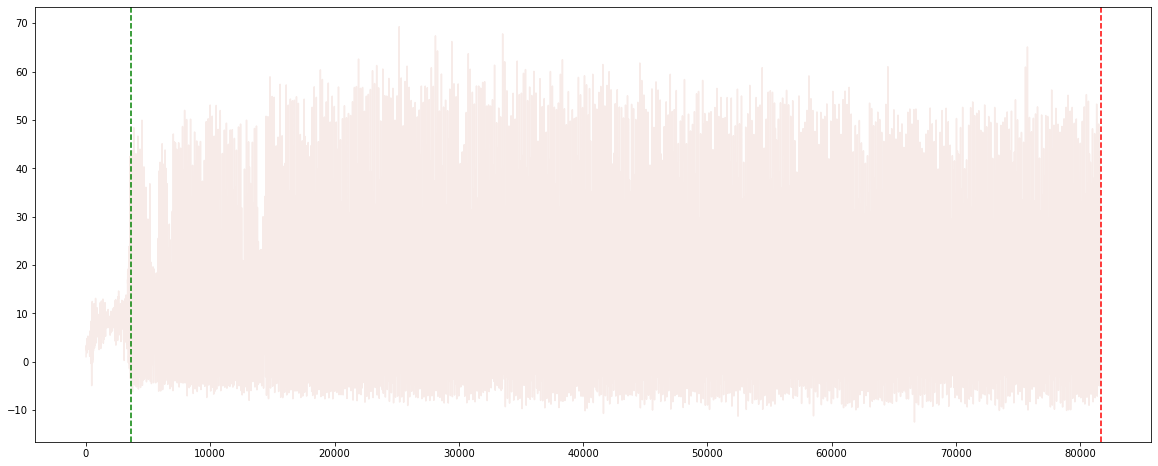

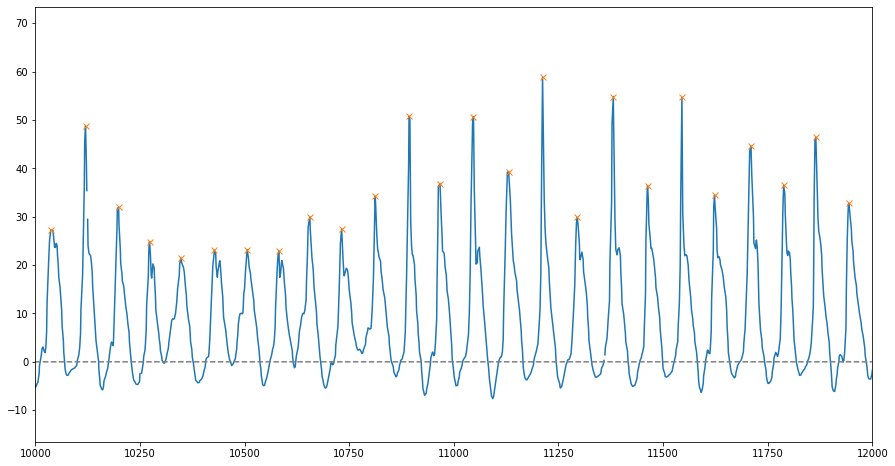

+++++++++++++++
Session Identifier:  0405
Number of observations excluded with inference method: 3200


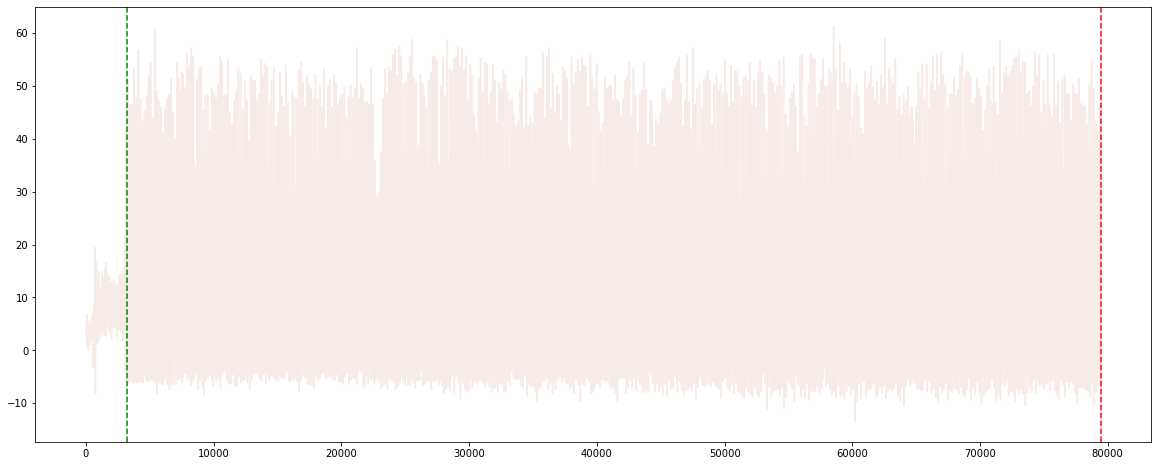

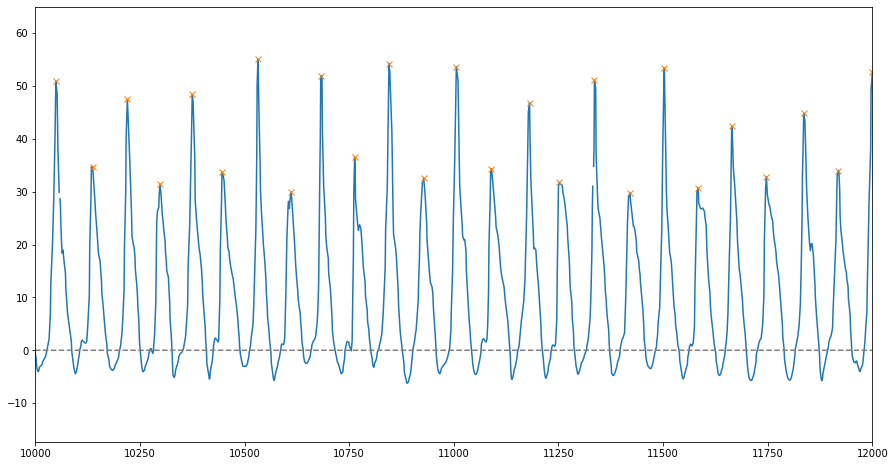

+++++++++++++++
Session Identifier:  0705
Number of observations excluded with inference method: 3300


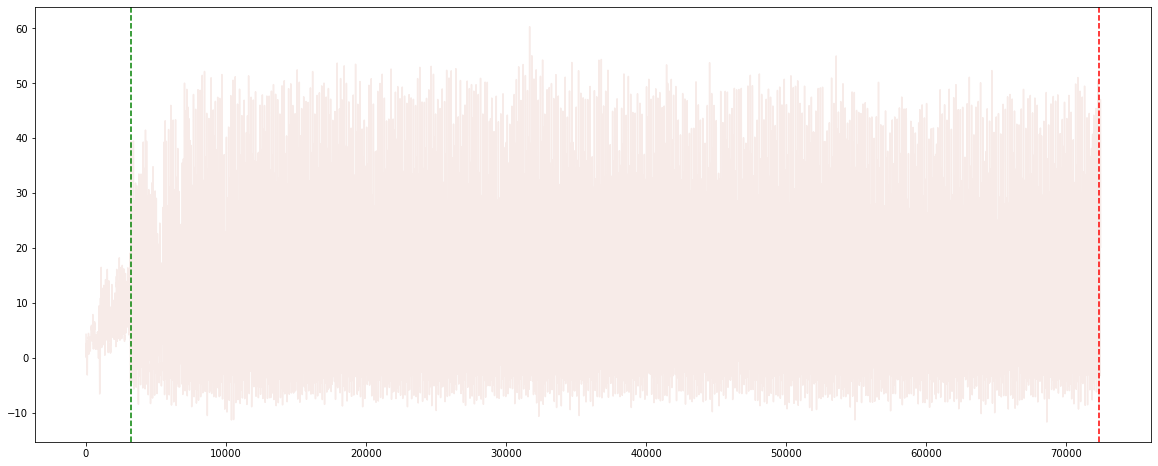

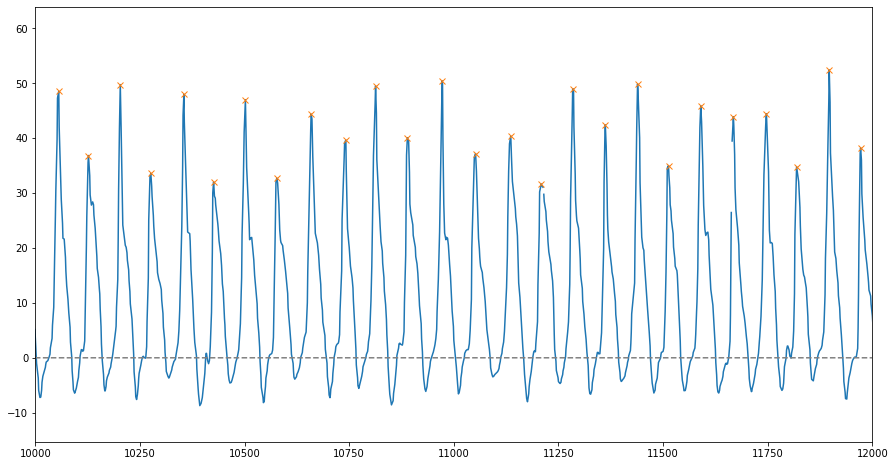

+++++++++++++++
Session Identifier:  1304
Number of observations excluded with inference method: 12100


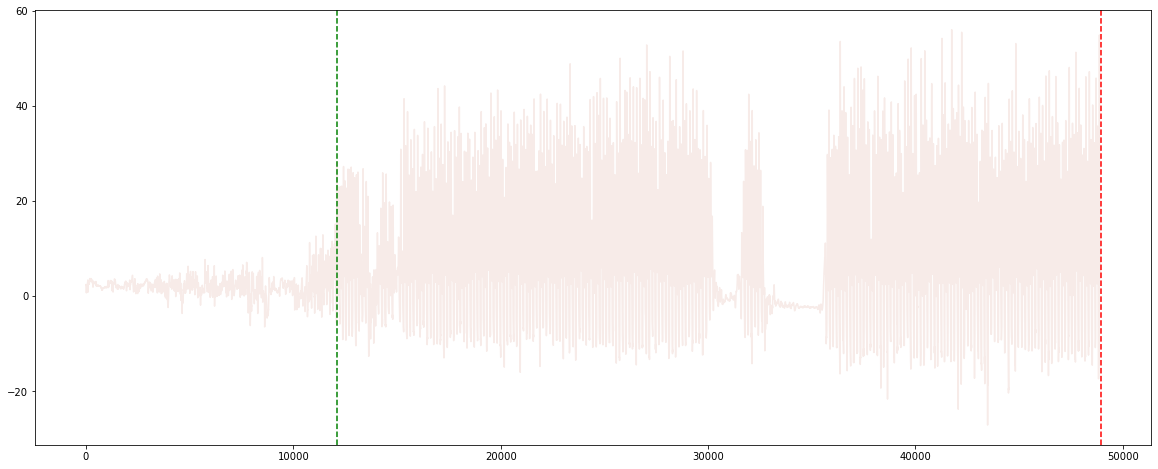

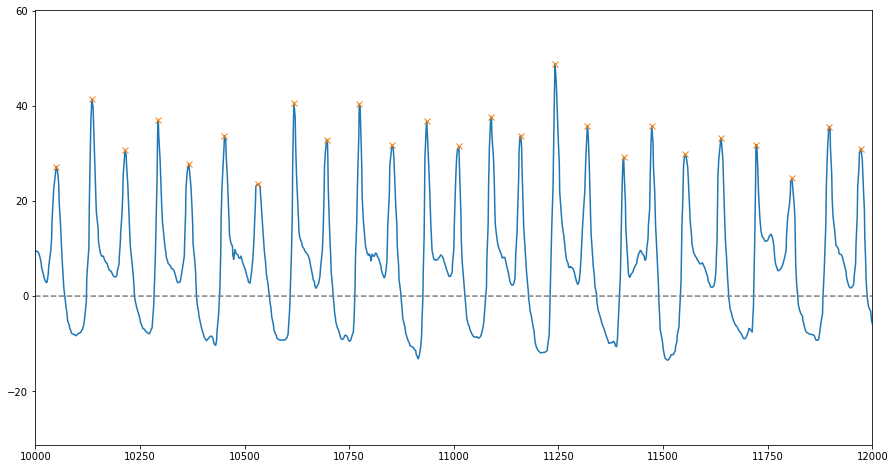

+++++++++++++++
Session Identifier:  1504
Number of observations excluded with inference method: 9600


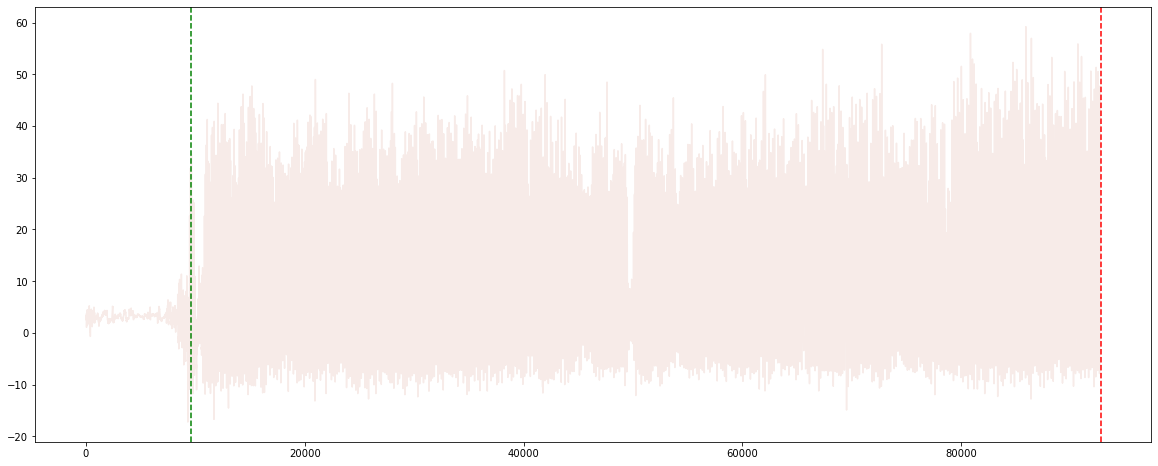

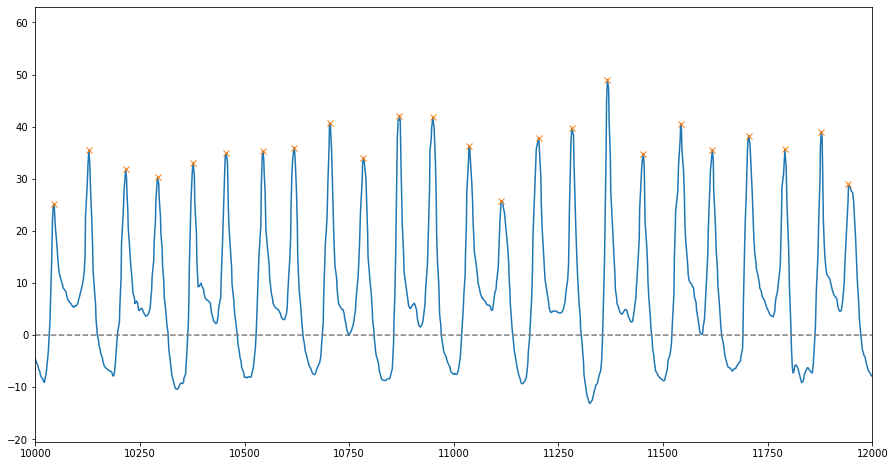

+++++++++++++++
Session Identifier:  1604
Number of observations excluded with inference method: 10000


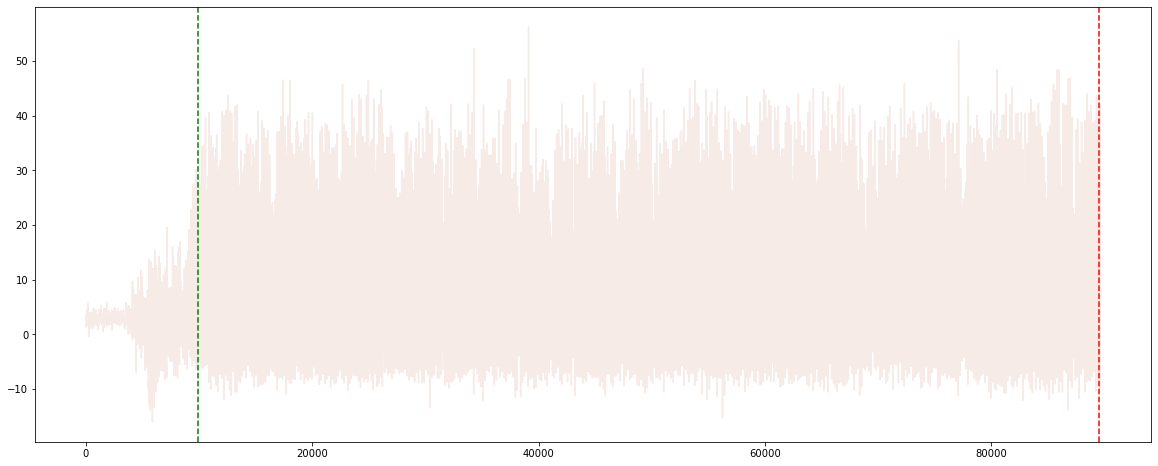

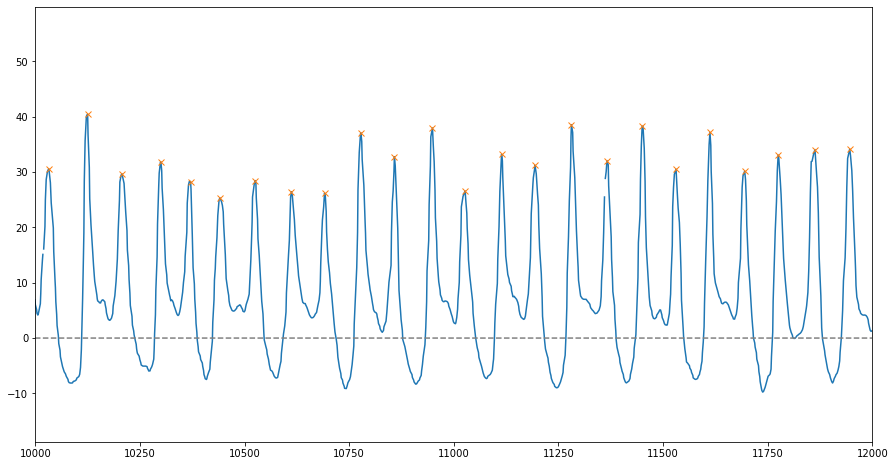

+++++++++++++++
Session Identifier:  2104
Number of observations excluded with inference method: 2600


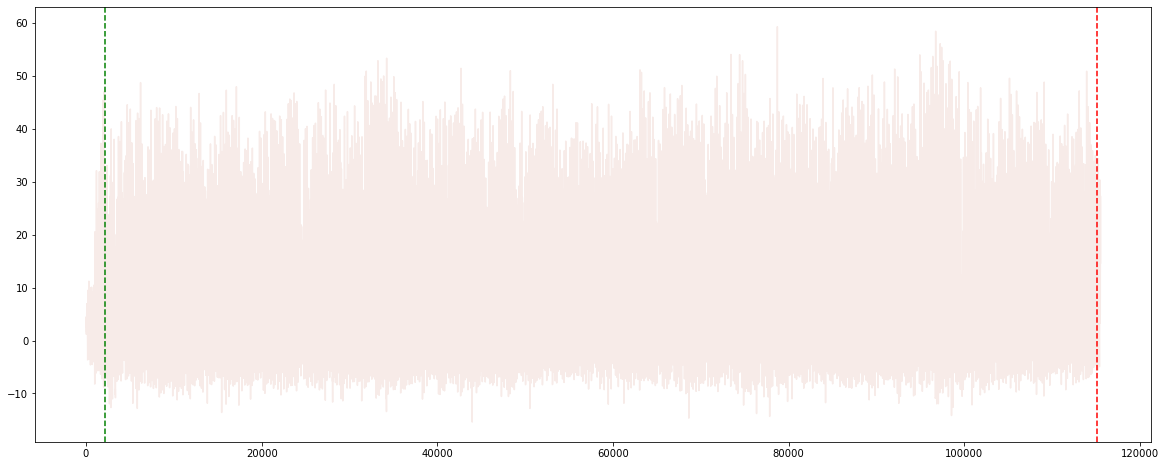

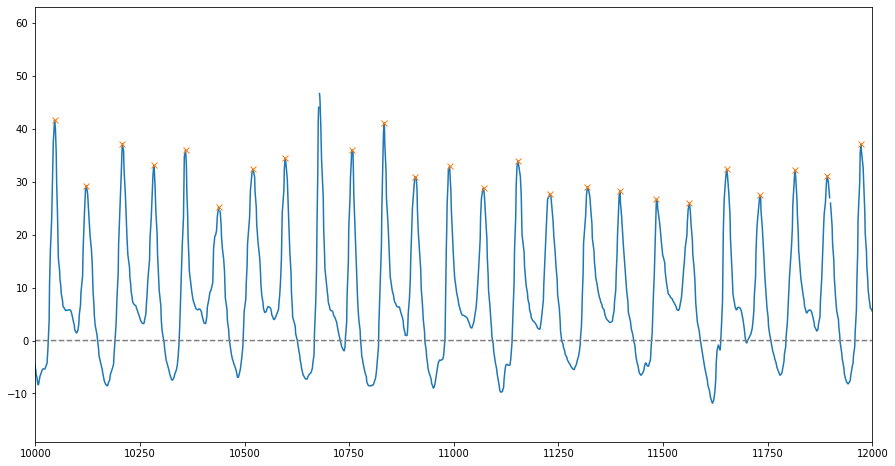

+++++++++++++++
Session Identifier:  2204
Number of observations excluded with inference method: 2500


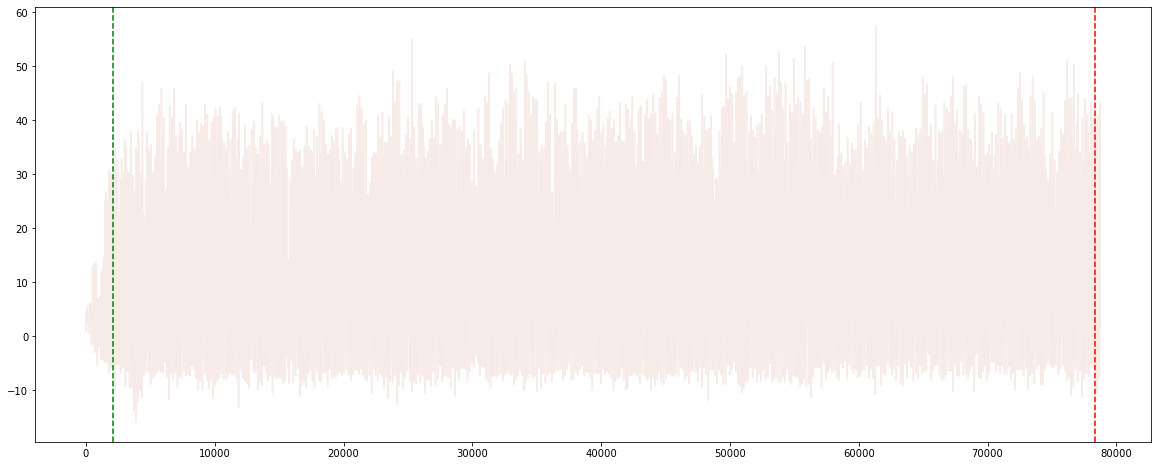

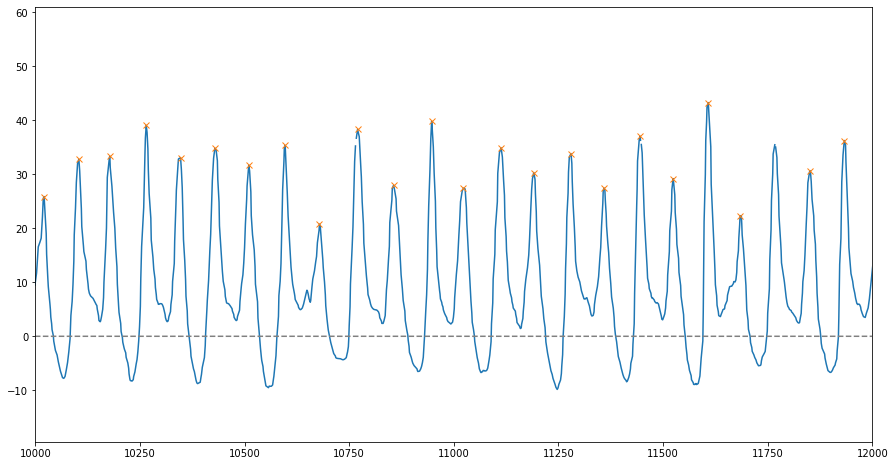

+++++++++++++++
Session Identifier:  2404
Number of observations excluded with inference method: 2000


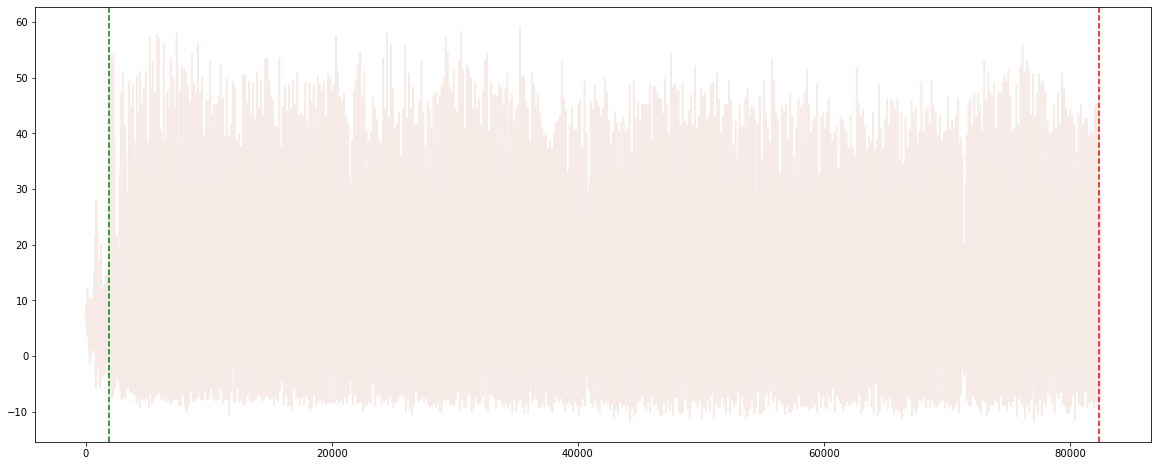

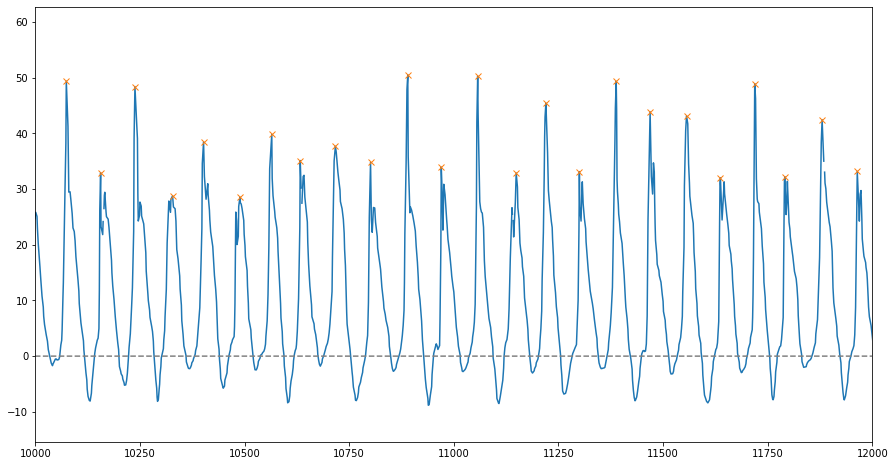

+++++++++++++++
Session Identifier:  2704
Number of observations excluded with inference method: 1000


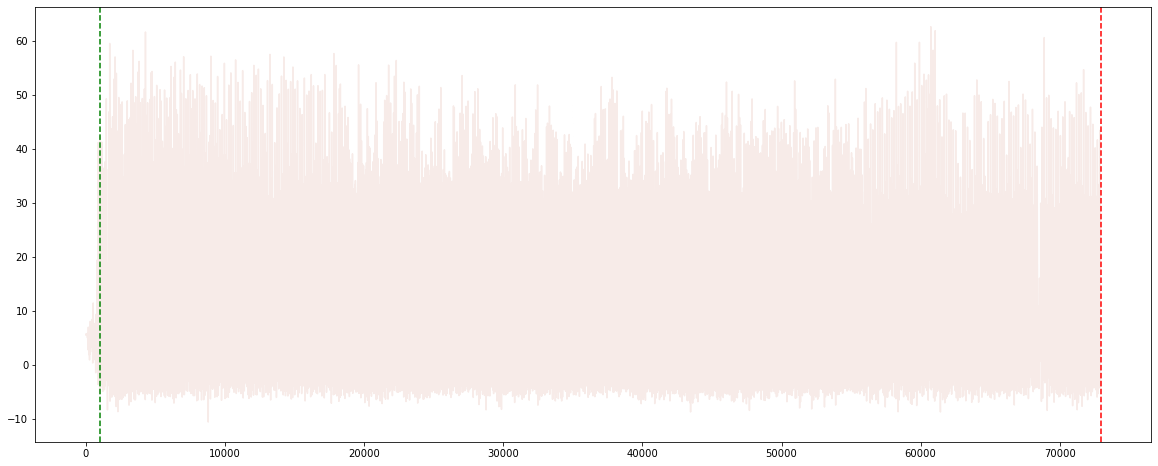

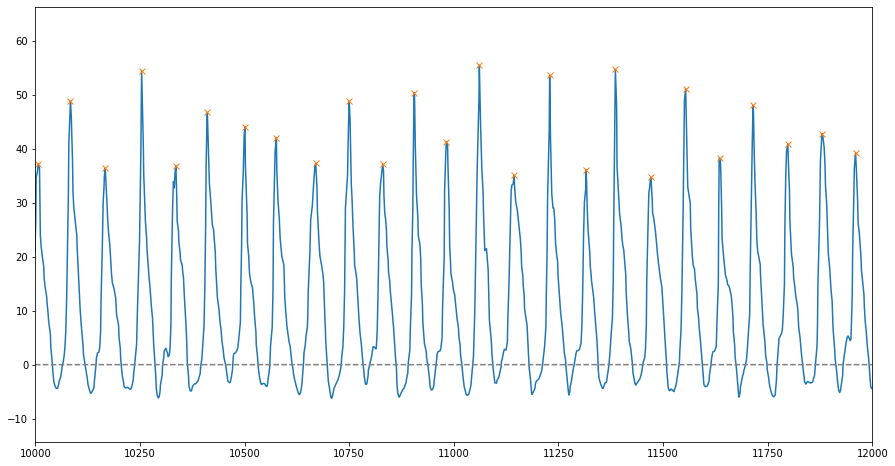

+++++++++++++++
Session Identifier:  3004
Number of observations excluded with inference method: 4400


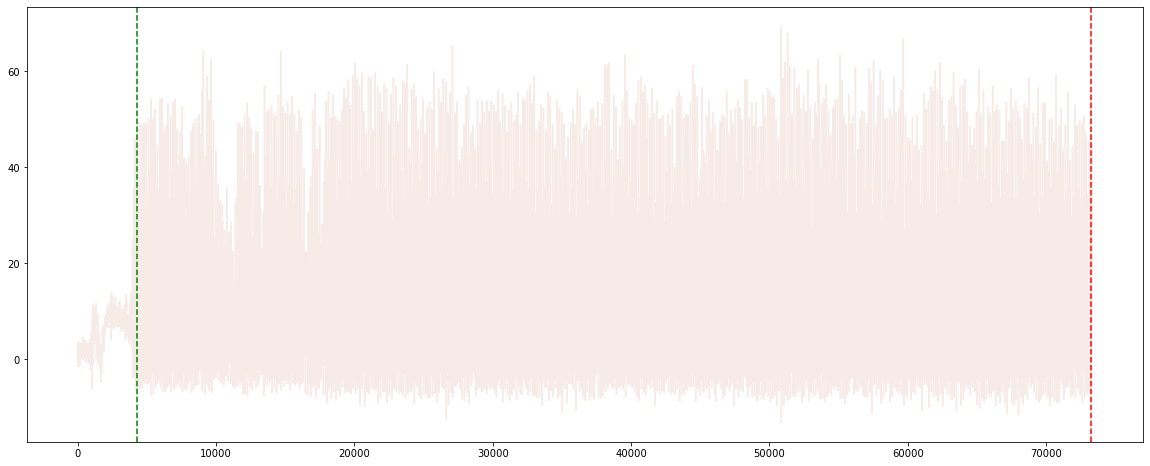

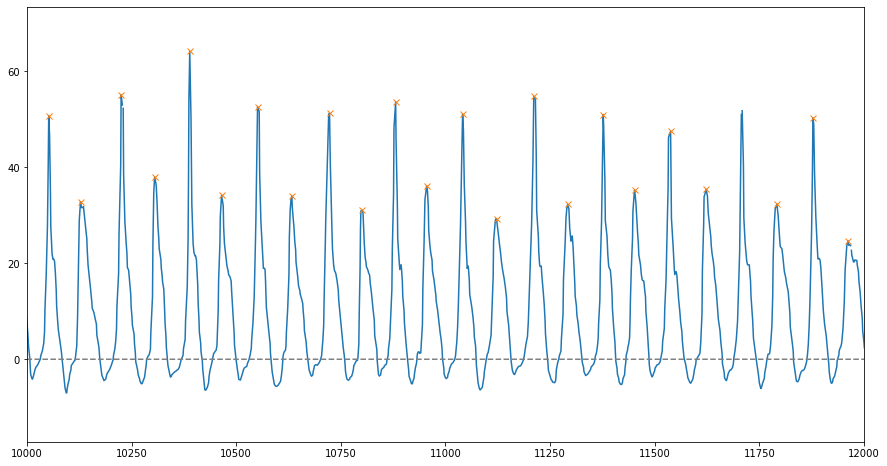

+++++++++++++++
Finished pre-processing individual time series


In [379]:
pd.set_option('mode.chained_assignment', None)

full = generate_full_time_series_AJ('../Data/Juan/Run/', #file_identifier='Run_2404',
                                    plot=False, google_files=file_names, period=1,
                                    independence_df=True, distance=distance_vec, feature='AccY', 
                                    plot_check=[10000,12000], history=2, step_per_peak=1)

In [381]:
full

,AccX_min,AccX_max,AccX_mean,AccX_median,AccX_std,AccY_min,AccY_max,AccY_mean,AccY_median,AccY_std,...,pace_min_previous_1,pace_min_previous_2,pace_max_previous_1,pace_max_previous_2,pace_mean_previous_1,pace_mean_previous_2,pace_median_previous_1,pace_median_previous_2,pace_std_previous_1,pace_std_previous_2
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-04-15 17:30:35,-11.569229,39.031799,4.007133,2.609838,8.795683,-9.432724,46.322433,8.715181,5.652428,12.393559,...,9.761128,9.761128,9.763627,9.763627,9.761787,9.761929,9.761684,9.761656,0.000675,0.000941
2021-04-15 17:30:40,-8.882095,54.704773,4.887974,2.313934,10.649927,-10.636307,55.798019,8.594355,4.976852,13.792427,...,9.761128,9.761128,9.763627,9.763627,9.761780,9.761787,9.761684,9.761684,0.000677,0.000675
2021-04-15 17:30:45,-9.786575,33.095200,3.710004,2.675247,7.887857,-8.963730,40.060425,8.885811,5.508057,12.015718,...,9.761128,9.761128,9.763627,9.763627,9.761768,9.761780,9.761684,9.761684,0.000670,0.000677
2021-04-15 17:30:50,-13.538528,22.494995,2.709037,1.493187,7.107438,-7.185867,38.584045,9.379736,6.130198,11.168002,...,9.761128,9.761128,9.763627,9.763627,9.761763,9.761768,9.761684,9.761684,0.000654,0.000670
2021-04-15 17:30:55,-10.320175,44.614243,3.960852,3.073647,8.305928,-7.621353,41.455444,8.603309,5.927999,11.875641,...,9.761128,9.761128,9.763627,9.763627,9.761778,9.761763,9.761684,9.761684,0.000682,0.000654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-07 18:39:05,-19.061157,14.011246,-1.288764,0.198074,7.635532,-8.044891,47.779663,10.462031,6.663799,13.254961,...,10.085006,10.085006,10.087588,10.536755,10.085645,10.483295,10.085580,10.534658,0.000642,0.143139
2021-05-07 18:39:10,-20.690674,14.045944,-1.381873,-0.628044,7.480265,-11.701126,48.306091,10.433175,6.615936,13.221142,...,10.085006,10.085006,10.087588,10.087588,10.085668,10.085645,10.085580,10.085580,0.000671,0.000642
2021-05-07 18:39:15,-16.139526,15.163391,-0.930170,-0.044596,7.443753,-7.126038,47.884949,10.053970,5.412346,13.326618,...,10.085006,10.085006,10.087588,10.087588,10.085673,10.085668,10.085580,10.085580,0.000703,0.000671


In [390]:
full.step_sum

timestamp
2021-04-15 17:30:35    13
2021-04-15 17:30:40    13
2021-04-15 17:30:45    12
2021-04-15 17:30:50    14
2021-04-15 17:30:55    13
                       ..
2021-05-07 18:39:05    14
2021-05-07 18:39:10    13
2021-05-07 18:39:15    13
2021-05-07 18:39:20    14
2021-05-07 18:39:25    12
Name: step_sum, Length: 595, dtype: int64

## Modelling part

In [398]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.inspection import permutation_importance
from sklearn.model_selection import ParameterGrid
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn import metrics

In [445]:
df_train, df_test = train_test_split(full, test_size=0.25, random_state=42)

In [467]:
# Random Forest Parameter Grid
param_grid_RF = {
    'max_depth': [10, 20, 30, 100],
    'n_estimators': [100, 150, 200],
                 'class_weight':['balanced']
}
param_grid_RF_list = list(ParameterGrid(param_grid_RF))

In [468]:
# SVM Parameter Grid
param_grid_SV = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
}
param_grid_SV_list = list(ParameterGrid(param_grid_SV))

In [469]:
# Linear SVM Parameter Grid
param_grid_LS = {
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge'],
    'C': [0.001, .1, 5],
}
param_grid_LS_list = list(ParameterGrid(param_grid_LS))

In [470]:
# XGBoost Parameter Grid
param_grid_XG = {'max_depth':[3, 6, 9],
              'min_child_weight':[1, 6],
              'learning_rate': [0.0001, 0.1]}
param_grid_XG_list = list(ParameterGrid(param_grid_XG))

In [475]:
# Logistic Regression Parameter Grid
param_grid_LR = {'penalty':['l1'],
                 'C':[0.01, 0.5, 1],
                 'solver': ['saga'],
                 'max_iter': [100000],
                 'multi_class':['multinomial'],
                 'class_weight':['balanced']}
param_grid_LR_list = list(ParameterGrid(param_grid_LR))

In [476]:
params = {'LR':param_grid_LR, 
          'XG':param_grid_XG, 
          'LS':param_grid_LS, 
          'SV':param_grid_SV,
          'RF':param_grid_RF}

In [477]:
class_dict = {'LR':LogisticRegression, 
              'RF':RandomForestClassifier}

In [ ]:
features = df_train.columns.to_list()
features.remove('step_sum')
target_var = 'step_sum'

y_train = df_train[target_var]
X_train = df_train[features]

score_param = []
for model_id, model in class_dict.items():
    print(model_id)
    mdl=model(random_state=42)
    CV_rfc = GridSearchCV(estimator=mdl, param_grid=params[model_id], cv= 5)
    CV_rfc.fit(X_train, y_train)
    score_param.append((model_id, CV_rfc.best_params_, CV_rfc.best_score_))

score_df = pd.DataFrame(score_param, columns=['Model', 'Params', 'Score'])

LR


C:\Users\juanm\Anaconda3\envs\data_science_general\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [ ]:
score_df